In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Load library for Augmented Deckey Fuller(ADF) test to test the stationarity 
#of the data; It also contains ACF and PACF tests for knowing q and p values
from statsmodels.tsa.stattools import adfuller,acf,pacf
#import ARIMA model
from statsmodels.tsa.arima_model import ARIMA
#to extract different time series components
from statsmodels.tsa.seasonal import seasonal_decompose
#to find whether my residuals are having white noise
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [3]:
'''
          ### Read External Data ###
'''


#read data
salesdata = pd.read_csv('SuperStore.csv',parse_dates=['Order Date'])
#analyse data & columns 
salesdata.head(10)
salesdata.columns
salesdata.index

RangeIndex(start=0, stop=2121, step=1)

In [4]:
'''
          ### Data Exploration and Preparation ###
'''


#Select only those columns which are needed for model building 
#Selected features: 'Order Date','Sales' into new data as we wish to predict next year Sales
newdata = pd.DataFrame(data=salesdata,columns=['Order Date','Sales'])
#display new data
newdata.head()

#Need to set index for the new data as Date column
newdata.set_index('Order Date')

type(newdata['Order Date'])

pandas.core.series.Series

In [5]:
#Convert date into datetime format
newdata['Order Date'] = pd.to_datetime(newdata['Order Date'],errors='coerce')
format(newdata['Order Date']) #check datetime format

'0      2016-11-08\n1      2016-11-08\n2      2015-10-11\n3      2014-06-09\n4      2014-06-09\n          ...    \n2116   2015-03-19\n2117   2016-12-05\n2118   2015-09-06\n2119   2014-01-21\n2120   2017-02-26\nName: Order Date, Length: 2121, dtype: datetime64[ns]'

In [8]:
#Group the data monthly for each year and sort it 
# 1. We will use aggregate method sum() to add sales values
monthdata = newdata.groupby(newdata['Order Date'].dt.strftime('%y-%m'))['Sales'].sum()
#analyse the data
len(monthdata)
monthdata.head(20)

Order Date
14-01     6242.5250
14-02     1839.6580
14-03    14573.9560
14-04     7944.8370
14-05     6912.7870
14-06    13206.1256
14-07    10821.0510
14-08     7320.3465
14-09    23816.4808
14-10    12304.2470
14-11    21564.8727
14-12    30645.9665
15-01    11739.9416
15-02     3134.3740
15-03    12499.7830
15-04    10475.6985
15-05     9374.9505
15-06     7714.1790
15-07    13674.4200
15-08     9638.5922
Name: Sales, dtype: float64

In [9]:
#Its a series data and dosenot contain the columnname for Sales. 
#Convert to a dataframe to include column name
monthdata=pd.DataFrame(data= monthdata, columns=['Sales'])
monthdata.head(20)

,Sales
Order Date,
14-01,6242.5250
14-02,1839.6580
14-03,14573.9560
14-04,7944.8370
14-05,6912.7870
14-06,13206.1256
14-07,10821.0510
14-08,7320.3465
14-09,23816.4808


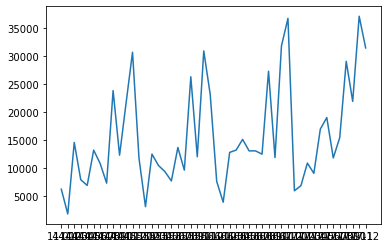

In [16]:
#Lets visualize the data 
plt.plot(monthdata)

In [19]:
#Data seems to have the seasonality
#check missing values
monthdata['Sales'].isna()
monthdata['Sales'].isnull().sum()
#No missing/null/na value
#as there are no missing values/nullvalues and now our data is ready to proceed with
print(monthdata)

                 Sales
Order Date            
14-01        6242.5250
14-02        1839.6580
14-03       14573.9560
14-04        7944.8370
14-05        6912.7870
14-06       13206.1256
14-07       10821.0510
14-08        7320.3465
14-09       23816.4808
14-10       12304.2470
14-11       21564.8727
14-12       30645.9665
15-01       11739.9416
15-02        3134.3740
15-03       12499.7830
15-04       10475.6985
15-05        9374.9505
15-06        7714.1790
15-07       13674.4200
15-08        9638.5922
15-09       26273.0230
15-10       12026.6235
15-11       30880.8325
15-12       23085.8192
16-01        7622.7430
16-02        3925.5510
16-03       12801.0920
16-04       13212.0900
16-05       15119.8350
16-06       13070.5720
16-07       13068.5190
16-08       12483.2323
16-09       27262.8809
16-10       11872.5770
16-11       31783.6288
16-12       36678.7150
17-01        5964.0320
17-02        6866.3374
17-03       10893.4448
17-04        9065.9581
17-05       16957.5582
17-06      

In [21]:
# 2. We will use aggregate method avg() to add sales values
monthdata1 = newdata.groupby(newdata['Order Date'].dt.strftime('%y-%m'))['Sales'].mean()
monthdata1
len(monthdata1)
type(monthdata1)
#Convert to a dataframe to include column name
monthdata1=pd.DataFrame(data= monthdata1, columns=['Sales'])
monthdata1.head(20)

,Sales
Order Date,
14-01,312.126250
14-02,262.808286
14-03,441.635030
14-04,305.570654
14-05,288.032792
14-06,440.204187
14-07,327.910636
14-08,305.014437
14-09,425.294300


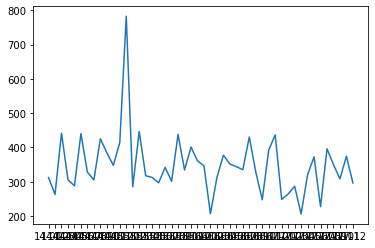

In [22]:
plt.plot(monthdata1)

In [23]:
'''
          ### Feature Engineering ###
'''

#Check the stationarity in the data
#Lets use Augmented Deckey Fuller(ADF) test to get the pvalue
def checkStationarity(data):
    pvalue = adfuller(data)[1] #interested in only 2nd value=pvalue
    if(pvalue<0.05):
        msg = 'The data is stationary as pvalue = {}'.format(pvalue)
    else:
        msg = 'The data is not stationary as pvalue = {}'.format(pvalue)
    return(msg)
print(checkStationarity(monthdata)) # sum() data

The data is stationary as pvalue = 8.450793985809654e-05


In [24]:
print(checkStationarity(monthdata1)) # average() data

The data is stationary as pvalue = 9.093398510006677e-10


Text(0.5, 1.0, 'Monthly Sales data for the year 2014')

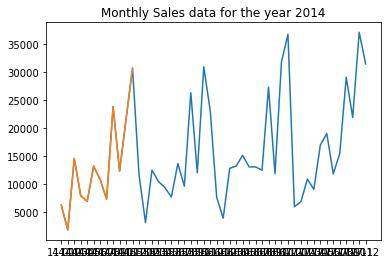

In [25]:
#As our data is stationary, we do not need any further processing for making it stationary
#monthdata with sum aggregation
#lets plot the data first to understand the trend and seasonality
plt.plot(monthdata['Sales'])
plt.title("Monthly Sales data from 2014 to 2017")
#yearly plot
plt.plot(monthdata['Sales'][0:12])
plt.title("Monthly Sales data for the year 2014")

Text(0.5, 1.0, 'Monthly Sales data for the year 2014')

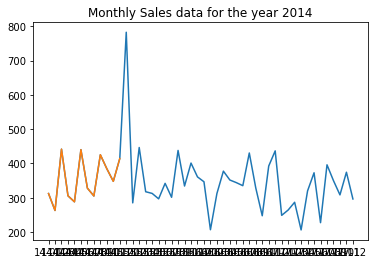

In [26]:
#monthdata with average aggregation
#lets plot the data first to understand the trend and seasonality
plt.plot(monthdata1['Sales'])
plt.title("Monthly Sales data from 2014 to 2017")
#yearly plot
plt.plot(monthdata1['Sales'][0:12])
plt.title("Monthly Sales data for the year 2014")

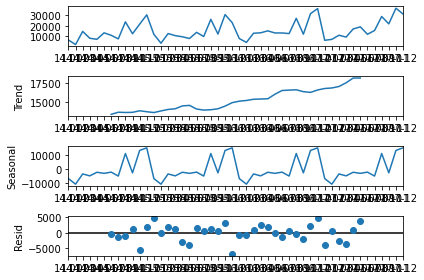

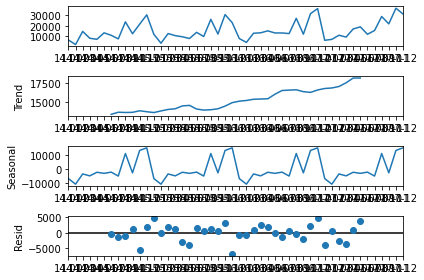

In [27]:
#Lets decompose the data to get further clarification 
#extract the components of time series data
#seasonality, trend

seasonal_decompose(monthdata,period=12).plot()
# we can observe a upward trend and seasonwise picks in the data

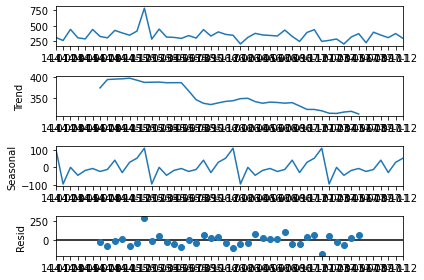

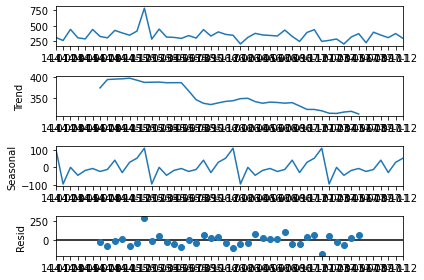

In [28]:
#Lets do it for aggregate method avg()
seasonal_decompose(monthdata1,period=12).plot()
# we can observe a downward trend and seasonwise picks in the data

#Hence it is a data with both Trend & Seasons 

In [29]:
'''
          ### Model Comparison ###
'''

############  For data with aggregation method = average/mean()
lags = 20
lag_acf = acf(monthdata1,nlags=lags)
lag_pacf = pacf(monthdata1,nlags=lags,method='ols')

D:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Auto Correlation(ACF)')

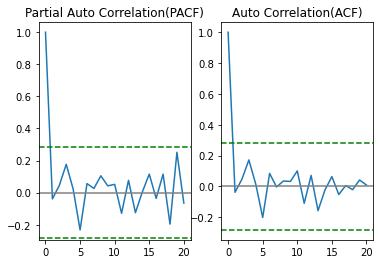

In [30]:
#Plot the correlogram to determine optimum p and q 
#Confidence level at 97.5% we have z score = +- 1.96
#plot the pacf
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthdata1)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(monthdata1)),linestyle='--',color='green')
plt.title('Partial Auto Correlation(PACF)')  
#We get significant values of p at lags = 0

#plot the acf
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthdata1)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(monthdata1)),linestyle='--',color='green')
plt.title('Auto Correlation(ACF)')  
#We get significant values of q at lags  = 0

Text(0.5, 1.0, 'Auto Correlation(ACF)')

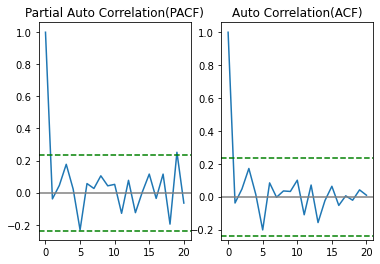

In [31]:
#Confidence level at 95% we have z score = +- 1.645
#plot the pacf
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.645/np.sqrt(len(monthdata1)),linestyle='--',color='green')
plt.axhline(y=1.645/np.sqrt(len(monthdata1)),linestyle='--',color='green')
plt.title('Partial Auto Correlation(PACF)')  
#We get significant values of p at lags = 0

#plot the acf
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.645/np.sqrt(len(monthdata1)),linestyle='--',color='green')
plt.axhline(y=1.645/np.sqrt(len(monthdata1)),linestyle='--',color='green')
plt.title('Auto Correlation(ACF)')  
#We get significant values of q at lags  = 0

In [32]:
#Train test spilt: Has to be squential for time series not random split
trainx = monthdata1[0:36]
len(trainx)
testx = monthdata1[36:]
len(testx)

12

In [33]:
#Lets build ARIMA model
p=0;d=0;q=0
m1 = ARIMA(trainx,order=(p,d,q)).fit()
m1.summary()

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.wa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                     ARMA(0, 0)   Log Likelihood                -214.165
Method:                           css   S.D. of innovations             92.768
Date:                Tue, 13 Jul 2021   AIC                            432.331
Time:                        19:40:56   BIC                            435.498
Sample:                             0   HQIC                           433.436
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        360.5920     15.461     23.322      0.000     330.288     390.896
==============================================================================
"""

In [34]:
#test model goodness
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1])[1]
if(pvalue<0.05):
    print('Reject H0:Bad Model')
else:
    print('Fail to Reject H0:Good Model')

Fail to Reject H0:Good Model


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [35]:
#Check the AIC/BIC Scores

print("AIC= {}\n BIC={}".format(m1.aic,m1.bic))

AIC= 432.3308620856929
 BIC=435.4978999626051


In [36]:
#Get predictions
pred = m1.forecast(steps=len(testx))[0]
pred

array([360.59202487, 360.59202487, 360.59202487, 360.59202487,
       360.59202487, 360.59202487, 360.59202487, 360.59202487,
       360.59202487, 360.59202487, 360.59202487, 360.59202487])

In [37]:
#cretae a dataframe to store actual and predicted
df = pd.DataFrame({'Actual':testx.Sales,'Forecast':pred})
print(df)

                Actual    Forecast
Order Date                        
17-01       248.501333  360.592025
17-02       264.089900  360.592025
17-03       286.669600  360.592025
17-04       206.044502  360.592025
17-05       319.953928  360.592025
17-06       372.717386  360.592025
17-07       227.173500  360.592025
17-08       395.945487  360.592025
17-09       349.737422  360.592025
17-10       308.226313  360.592025
17-11       374.310253  360.592025
17-12       296.296857  360.592025


In [38]:
mse = mean_squared_error(df.Actual,df.Forecast)
mse
print("MSE= {}, RMSE = {}".format(mse,np.sqrt(mse)))

MSE= 6604.7785739813635, RMSE = 81.26978881467186


In [39]:
#Build few(6) models and select best model
#Calculate MSE/RMSE
#Calculate AIC/BIC scores
p_list = range(3)
d =0
q_list= range(2)
df1 = pd.DataFrame(columns=['p','d','q','AIC','BIC','MSE',"RMSE"])
for p in p_list:
    for q in q_list:
        m2 = ARIMA(trainx,order=(p,d,q)).fit()
        m2.summary()
                    
        pred = m2.forecast(steps=len(testx))[0]
        df = pd.DataFrame({'Actual':testx.Sales,'Forecast':pred})
        mse = mean_squared_error(df.Actual,df.Forecast)
        df1 = df1.append({'p':p,'d':d,'q':q,'AIC':m2.aic,'BIC':m2.bic,'MSE':mse,"RMSE":np.sqrt(mse)},ignore_index=True)
                
print(df1)

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.wa

     p    d    q         AIC         BIC          MSE       RMSE
0  0.0  0.0  0.0  432.330862  435.497900  6604.778574  81.269789
1  0.0  0.0  1.0  434.093295  438.843852  6486.042625  80.535971
2  1.0  0.0  0.0  434.088837  438.839393  6492.924425  80.578685
3  1.0  0.0  1.0  434.672662  441.006738  7329.115711  85.610255
4  2.0  0.0  0.0  436.088836  442.422912  6493.174174  80.580234
5  2.0  0.0  1.0  438.084331  446.001925  6473.408976  80.457498


In [40]:
#We will choose the model with least RMSE 
#i.e.with df1: p= 2.0, d= 0.0, q= 1.0 ,aic= 438.084331 ,bic= 446.001925,mse=  6473.408976,rmse=  80.457498
m3 = ARIMA(trainx,order=(2,0,1)).fit()
m3.summary()

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.wa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                     ARMA(2, 1)   Log Likelihood                -214.042
Method:                       css-mle   S.D. of innovations             92.442
Date:                Tue, 13 Jul 2021   AIC                            438.084
Time:                        19:43:22   BIC                            446.002
Sample:                             0   HQIC                           440.848
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         360.5411     14.150     25.479      0.000     332.807     388.276
ar.L1.Sales    -0.3332      2.280     -0.146      0.884      -4.801       4.135
ar.L2.Sales    -0.0315      0.247     -0.127      0.899      -0.516       0.453
ma.L1.Sales     0.2501      2.274      0.110      0.912      -4.207       4.707
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.2964           -1.9336j            5.6383           -0.4443
AR.2           -5.2964           +1.9336j            5.6383            0.4443
MA.1           -3.9976           +0.0000j            3.9976            0.5000
-----------------------------------------------------------------------------
"""

In [41]:
#Get the predictions on decided model
pred = m3.forecast(steps=len(testx))[0]
df = pd.DataFrame({'Actual':testx.Sales,'Forecast':pred})
print(df)

                Actual    Forecast
Order Date                        
17-01       248.501333  353.611199
17-02       264.089900  360.456116
17-03       286.669600  360.787440
17-04       206.044502  360.461729
17-05       319.953928  360.559836
17-06       372.717386  360.537391
17-07       227.173500  360.541784
17-08       395.945487  360.541026
17-09       349.737422  360.541141
17-10       308.226313  360.541126
17-11       374.310253  360.541128
17-12       296.296857  360.541128


Text(0.5, 1.0, 'Actual vs Forecast Sales(Aggregate Method=mean()')

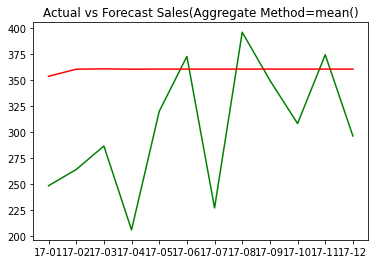

In [42]:
#Lets analyse the plot
plt.plot(testx.Sales,color='green')
plt.plot(pred,color='red')
plt.title("Actual vs Forecast Sales(Aggregate Method=mean()")

In [43]:
#It seems not a good fit for forcast
#Lets analyse the data with aggregate method= sum()
lags = 20
lag_acf = acf(monthdata,nlags=lags)
lag_pacf = pacf(monthdata,nlags=lags,method='ols')

D:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Auto Correlation(ACF)')

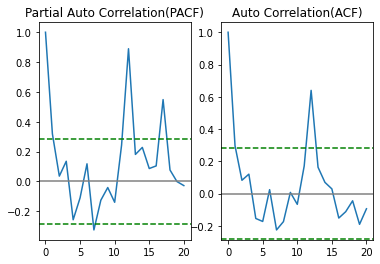

In [44]:
#Plot the correlogram to determine optimum p and q 
#Confidence level at 97.5% we have z score = +- 1.96
#plot the pacf
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthdata)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(monthdata)),linestyle='--',color='green')
plt.title('Partial Auto Correlation(PACF)')  
#We get significant values of p at lags = 0,7, 12.5,13,15,17,20

#plot the acf
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthdata)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(monthdata)),linestyle='--',color='green')
plt.title('Auto Correlation(ACF)')  
#We get significant values of q at lags  = 0, 13
#We get significant values of p and q at lags = 0 and 13

In [45]:
#Train test spilt: Has to be squential for time series not random split
trainx = monthdata[0:36]
len(trainx)
testx = monthdata[36:]
len(testx)

12

In [46]:
#Build few models and select best model
#Calculate MSE/RMSE
#Calculate AIC/BIC scores
p_list = range(4)
d =0
q_list= range(2)
df1 = pd.DataFrame(columns=['p','d','q','AIC','BIC','MSE',"RMSE"])
for p in p_list:
    for q in q_list:
        m2 = ARIMA(trainx,order=(p,d,q)).fit()
        m2.summary()
                    
        pred = m2.forecast(steps=len(testx))[0]
        df = pd.DataFrame({'Actual':testx.Sales,'Forecast':pred})
        mse = mean_squared_error(df.Actual,df.Forecast)
        df1 = df1.append({'p':p,'d':d,'q':q,'AIC':m2.aic,'BIC':m2.bic,'MSE':mse,"RMSE":np.sqrt(mse)},ignore_index=True)
                
print(df1)

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.wa

     p    d    q         AIC         BIC           MSE          RMSE
0  0.0  0.0  0.0  758.554777  761.721815  1.048332e+08  10238.807037
1  0.0  0.0  1.0  758.420398  763.170955  1.121545e+08  10590.304525
2  1.0  0.0  0.0  758.110302  762.860859  1.191525e+08  10915.701154
3  1.0  0.0  1.0  759.811611  766.145687  1.291909e+08  11366.215992
4  2.0  0.0  0.0  759.875635  766.209711  1.285955e+08  11339.996998
5  2.0  0.0  1.0  761.787567  769.705162  1.309676e+08  11444.106020
6  3.0  0.0  0.0  761.392713  769.310308  1.317800e+08  11479.545741
7  3.0  0.0  1.0  763.200454  772.701568  1.306369e+08  11429.648196


In [47]:
#We will choose the model with least RMSE 
#'p',   'd',  'q','AIC',     'BIC',          'MSE',       "RMSE"
#  0.0  0.0  0.0  758.554777  761.721815  1.048332e+08  10238.807037
m4 = ARIMA(trainx,order=(0,0,0)).fit()
m4.summary()

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.wa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                     ARMA(0, 0)   Log Likelihood                -377.277
Method:                           css   S.D. of innovations           8612.664
Date:                Tue, 13 Jul 2021   AIC                            758.555
Time:                        19:47:02   BIC                            761.722
Sample:                             0   HQIC                           759.660
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.463e+04   1435.444     10.191      0.000    1.18e+04    1.74e+04
==============================================================================
"""

In [48]:
#Lets make predictions
pred = m4.forecast(steps=len(testx))[0]
df = pd.DataFrame({'Actual':testx.Sales,'Forecast':pred})
print(df)

                Actual      Forecast
Order Date                          
17-01        5964.0320  14628.125725
17-02        6866.3374  14628.125725
17-03       10893.4448  14628.125725
17-04        9065.9581  14628.125725
17-05       16957.5582  14628.125725
17-06       19008.5867  14628.125725
17-07       11813.0220  14628.125725
17-08       15441.8740  14628.125725
17-09       29028.2060  14628.125725
17-10       21884.0682  14628.125725
17-11       37056.7150  14628.125725
17-12       31407.4668  14628.125725


Text(0.5, 1.0, 'Actual vs Forecast Sales with Aggregate Method = sum()')

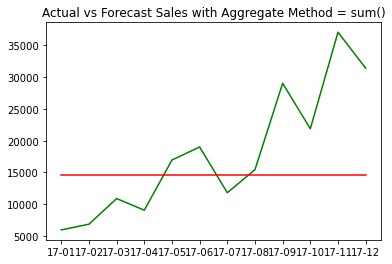

In [49]:
plt.plot(testx.Sales,color='green')
plt.plot(pred,color='red')
plt.title("Actual vs Forecast Sales with Aggregate Method = sum()")

In [50]:
#Above methods sum() and avg() doesnot seem to produce good models. 
#We must have take into account trend and seasonality into data.
'''
Lets de-trend the data using d= 1 and repeat the things for sum() data
#The data contains upward trend and hence need to de-trend it
# perform difference with by lag =1 i.e. d= 1
'''
diff_sales = monthdata - monthdata.shift()
print(diff_sales)

                 Sales
Order Date            
14-01              NaN
14-02       -4402.8670
14-03       12734.2980
14-04       -6629.1190
14-05       -1032.0500
14-06        6293.3386
14-07       -2385.0746
14-08       -3500.7045
14-09       16496.1343
14-10      -11512.2338
14-11        9260.6257
14-12        9081.0938
15-01      -18906.0249
15-02       -8605.5676
15-03        9365.4090
15-04       -2024.0845
15-05       -1100.7480
15-06       -1660.7715
15-07        5960.2410
15-08       -4035.8278
15-09       16634.4308
15-10      -14246.3995
15-11       18854.2090
15-12       -7795.0133
16-01      -15463.0762
16-02       -3697.1920
16-03        8875.5410
16-04         410.9980
16-05        1907.7450
16-06       -2049.2630
16-07          -2.0530
16-08        -585.2867
16-09       14779.6486
16-10      -15390.3039
16-11       19911.0518
16-12        4895.0862
17-01      -30714.6830
17-02         902.3054
17-03        4027.1074
17-04       -1827.4867
17-05        7891.6001
17-06      

In [51]:
#Remove the Null Value
len(diff_sales)
diff_sales.dropna(inplace=True)
len(diff_sales)
print(diff_sales)

                 Sales
Order Date            
14-02       -4402.8670
14-03       12734.2980
14-04       -6629.1190
14-05       -1032.0500
14-06        6293.3386
14-07       -2385.0746
14-08       -3500.7045
14-09       16496.1343
14-10      -11512.2338
14-11        9260.6257
14-12        9081.0938
15-01      -18906.0249
15-02       -8605.5676
15-03        9365.4090
15-04       -2024.0845
15-05       -1100.7480
15-06       -1660.7715
15-07        5960.2410
15-08       -4035.8278
15-09       16634.4308
15-10      -14246.3995
15-11       18854.2090
15-12       -7795.0133
16-01      -15463.0762
16-02       -3697.1920
16-03        8875.5410
16-04         410.9980
16-05        1907.7450
16-06       -2049.2630
16-07          -2.0530
16-08        -585.2867
16-09       14779.6486
16-10      -15390.3039
16-11       19911.0518
16-12        4895.0862
17-01      -30714.6830
17-02         902.3054
17-03        4027.1074
17-04       -1827.4867
17-05        7891.6001
17-06        2051.0285
17-07      

In [52]:
#Check stationarity
print(checkStationarity(diff_sales))

The data is stationary as pvalue = 5.167970563425365e-21


Text(0.5, 1.0, 'Actual vs Moving Average Data')

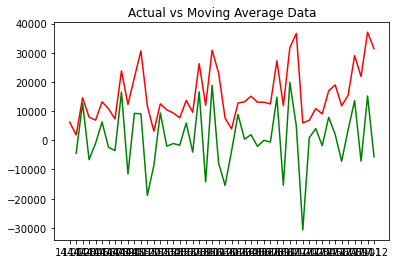

In [53]:
#Check stationarity through the plots
#Compare actual data vs moving average
plt.plot(111)
plt.plot(monthdata,color='red')
plt.plot(112)
plt.plot(diff_sales,color='green')
plt.title("Actual vs Moving Average Data")

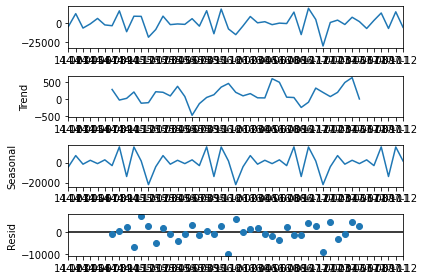

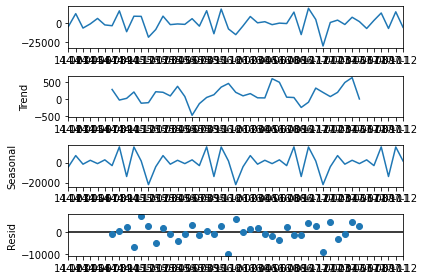

In [54]:
seasonal_decompose(diff_sales,period=12).plot()
#Now we could observe the trend has been removed

D:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Auto Correlation(ACF)')

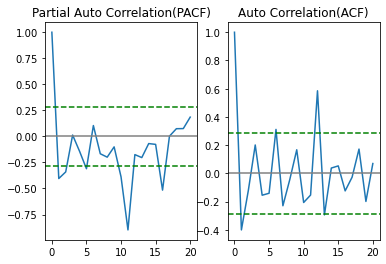

In [55]:
#Lets repeat all the procedures for model building
lags = 20
lag_acf = acf(diff_sales,nlags=lags)
lag_pacf = pacf(diff_sales,nlags=lags,method='ols')

#Plot the correlogram to determine optimum p and q 
#Confidence level at 97.5% we have z score = +- 1.96
#plot the pacf
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_sales)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(diff_sales)),linestyle='--',color='green')
plt.title('Partial Auto Correlation(PACF)')  
#We get significant values of p at lags = 0,7, 12.5,13,15,17,20

#plot the acf
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_sales)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(diff_sales)),linestyle='--',color='green')
plt.title('Auto Correlation(ACF)')  
#We get significant values of q at lags  = 0, 13
#We get significant values of p and q at lags = 0 and 13

In [56]:
#Train test spilt: Has to be squential for time series not random split
trainx = diff_sales[0:36]
len(trainx)
testx = diff_sales[36:]
len(testx)

11

In [57]:
#We will choose the model with least RMSE 
#p= 2, d= 1, q=4, AIC= 752.74 BIC=765.18, mse:60565886.48, rmse:7782.41
#After fine tuning the parameters we get the above set of parameters and we set those parameters for final ARIMA model buidling and forecast
#The final model is built bellow

p= 2; d=1;q=4
m4 = ARIMA(trainx,order=(p,d,q)).fit()
m4.summary()

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.wa

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -368.368
Method:                       css-mle   S.D. of innovations           7179.540
Date:                Tue, 13 Jul 2021   AIC                            752.736
Time:                        19:51:59   BIC                            765.179
Sample:                             1   HQIC                           757.032
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.3687     24.348      0.138      0.890     -44.352      51.090
ar.L1.D.Sales    -1.0314      0.065    -15.789      0.000      -1.159      -0.903
ar.L2.D.Sales    -0.9793      0.050    -19.738      0.000      -1.077      -0.882
ma.L1.D.Sales    -0.8557      0.484     -1.768      0.077      -1.804       0.093
ma.L2.D.Sales    -0.2886      0.220     -1.314      0.189      -0.719       0.142
ma.L3.D.Sales    -0.8557      0.201     -4.250      0.000      -1.250      -0.461
ma.L4.D.Sales     1.0000      0.478      2.094      0.036       0.064       1.936
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5266           -0.8625j            1.0105           -0.3372
AR.2           -0.5266           +0.8625j            1.0105            0.3372
MA.1           -0.5722           -0.8201j            1.0000           -0.3469
MA.2           -0.5722           +0.8201j            1.0000            0.3469
MA.3            1.0000           -0.0001j            1.0000           -0.0000
MA.4            1.0000           +0.0001j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [58]:
#Lets make predictions
pred = m4.forecast(steps=len(testx))[0]
df = pd.DataFrame({'Actual':testx.Sales,'Forecast':pred})
mse = mean_squared_error(df.Actual,df.Forecast)
print("p= {}, d= {}, q={}, AIC= {}\n BIC={}, mse:{}, rmse:{}".format(p,d,q,np.round(m4.aic,2),np.round(m4.bic,2),np.round(mse,2),np.round(np.sqrt(mse),2)))

                
print(df)

p= 2, d= 1, q=4, AIC= 752.74
 BIC=765.18, mse:60565886.48, rmse:7782.41
                Actual      Forecast
Order Date                          
17-02         902.3054  11351.492066
17-03        4027.1074  10158.834125
17-04       -1827.4867  -7455.878358
17-05        7891.6001    960.358991
17-06        2051.0285   9539.586161
17-07       -7195.5647  -7540.834918
17-08        3628.8520   1684.826438
17-09       13586.3320   8905.983307
17-10       -7144.1378  -7566.357591
17-11       15172.6468   2362.050430
17-12       -5649.2482   8262.905663


Text(0.5, 1.0, 'Actual vs Forecast Sales by Differencing')

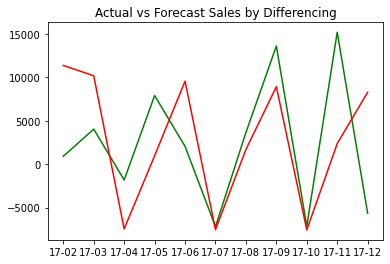

In [59]:
plt.plot(testx.Sales,color='green')
plt.plot(pred,color='red')
plt.title("Actual vs Forecast Sales by Differencing")
#Now the predictions seems to be quite aligned with the original data